# Find areas with no SEZ

This notebook identifies areas that are near SEZ, but outsize of the analysis radious of any SEZ, to use as a comparison to the growth of SEZ. 


In [1]:
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import rasterio.mask
from rasterio.plot import reshape_as_raster, reshape_as_image, show
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

%run ./lib.py

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')


In [2]:
sez_p = mp.open_package('http://library.metatab.org/worldbank.org-sez-1.1.1.csv')
ntl_p = mp.open_package('http://library.metatab.org/figshare.com-harmonized_ntl-1.1.1.csv')

<AxesSubplot:>

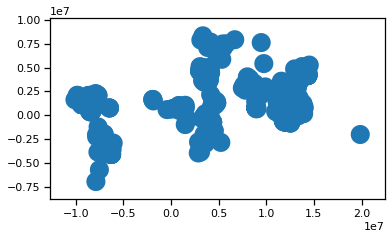

In [3]:
RADIUS = 5_000

# Create Dataframes
sez = sez_p.resource('sez').geoframe()

buf = sez.to_crs(3395).buffer(1000000)

buf.plot()

# Global Buffer Area

Create a buffer area, per country, and select points in it. 


<AxesSubplot:>

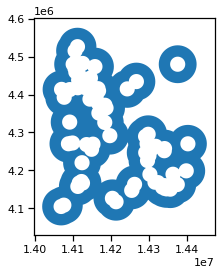

In [4]:
sez_k = sez[sez.country == 'Korea']

# Create two buffers at the two distances; in this case, 20K and 50kM from the center of the sez
sez_buf_20 = sez_k.to_crs(3395).buffer(20_000).unary_union
sez_buf_50 = sez_k.to_crs(3395).buffer(50_000).unary_union

# Taking a difference between them gives us a boundary region. 
sez_buf_50m20 = sez_buf_50.difference(sez_buf_20)
gpd.GeoSeries([sez_buf_50m20], crs=sez.crs).plot(aspect=1)


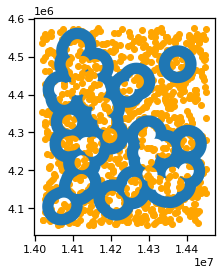

In [5]:
# Now we can find random points in the area. There are a few
# efficient was to do it, but the easy one is to produce random points over
# the whole total bounding box, then intersect the points with the
# boundary bands. 

# Here we create the random points and plot
# them with the boundary bands. 

from shapely.geometry import Point
from shapely.geometry import MultiPoint

no_sez_zone=gpd.GeoSeries([sez_buf_50m20], crs=sez.crs)
xmin, ymin, xmax, ymax = no_sez_zone.simplify(1000).total_bounds

x = np.random.uniform(xmin,xmax, 1000)
y = np.random.uniform(ymin,ymax, 1000)

points = gpd.GeoSeries([ Point(x_, y_) for x_, y_ in zip(x, y) ], crs=sez.crs)

ax=points.plot(aspect=1, color='orange')
ax = no_sez_zone.plot(aspect=1, ax=ax)

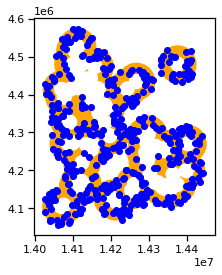

In [7]:
mpoints = MultiPoint(list(zip(x, y)))# Create a single shape of all of the points

t = mpoints.intersection(sez_buf_50m20) # Intersect with the boundary band

# Plot the intersected points and the boundary band. 
ax = no_sez_zone.plot(aspect=1, color='orange')
ax = gpd.GeoSeries(list(t.geoms), crs=sez.crs).plot(aspect=1, ax=ax,color ='blue')

<AxesSubplot:>

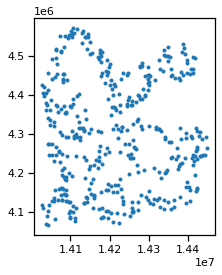

In [8]:
# Now package all of that process into a function, which
# we will run once for each country. Dividing by country makes
# the process more efficient, and attaches points to countries, 
# which may be useful for analysis. 

from shapely.geometry import Point
from shapely.geometry import MultiPoint

def no_sez_points(df, d1=20_000, d2=50_000, n=1000):
    """For df is a set of SEZ records ( usually for a single country ) return a n points that
        are between d1 and d2 meters from any sez in df"""

    sez_buf_20 = df.to_crs(3395).buffer(20_000).unary_union
    sez_buf_50 = df.to_crs(3395).buffer(50_000).unary_union

    sez_buf_50m20 = sez_buf_50.difference(sez_buf_20)

    no_sez_zone=gpd.GeoSeries([sez_buf_50m20], crs=df.crs)
    xmin, ymin, xmax, ymax = no_sez_zone.simplify(1000).total_bounds

    x = np.random.uniform(xmin,xmax, 1000)
    y = np.random.uniform(ymin,ymax, 1000)

    mpoints = MultiPoint(list(zip(x, y)))

    geoms = mpoints.intersection(sez_buf_50m20).geoms
    
    return gpd.GeoSeries(geoms, crs=sez.crs)

p = no_sez_points(sez[sez.country == 'Korea'], n=100)
p.plot(aspect=1, marker='.')
 

In [9]:

frames = []
for country, df in sez.groupby('country'):

    f = gpd.GeoDataFrame(geometry=no_sez_points(df, n=100), crs=sez.crs)
    f['country'] = country
    frames.append(f)
    
nsp = pd.concat(frames)   

<AxesSubplot:>

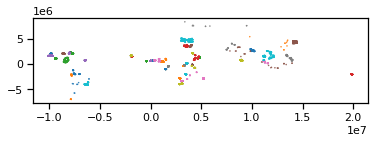

In [10]:
nsp.plot(column='country', aspect=.5, marker='.', markersize=1)